In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts

In [2]:
read_csv = False
s1218 = 1
years = 2015 - 1990 + 0.5
stop_loss = float('-inf')
duration_limit = 50

In [3]:
# MQO para encontrar o coeficiente de cointegração e criando a serie do spread
def OLS(data_ticker1, data_ticker2):
    spread = sm.OLS(data_ticker1,data_ticker2)
    spread = spread.fit()
    return data_ticker1 + (data_ticker2 * -spread.params.iloc[0]), spread.params.iloc[0]


# ADF test
def ADF(spread):
    return ts.adfuller(spread) # H0: Raiz unitária.


# Encontra o coeficiente de cointegração e realiza o ADF test
def ADF_test(data_ticker1, data_ticker2):
    ols = OLS(data_ticker1, data_ticker2)
    spread = ols[0]
    gamma = ols[1]
    return ADF(spread),gamma


# Encontra os pares cointegrados
def find_cointegrated_pairs_mod(data):
    try:
        print(f"Finding cointegrated pairs for shape {np.shape(data)}")
        n = data.shape[1]
        pvalue_matrix = np.ones((n, n))
        gammas_matrix= np.ones((n, n))
        keys = data.keys()
        for i in range(n):
            for j in range(i+1, n):
                S1 = keys[i]
                S2 = keys[j]
                #print(f"Testing cointegration for pairs {S1} and {S2}")
                result = ADF_test(data[S1], data[S2])
                gammas_matrix[i, j] =result[1] # gamma
                pvalue = result[0][1] # pvalue
                pvalue_matrix[i, j] = pvalue
            if(i%50 == 0):
                print(f"Finished pairs for stock {keys[i]}")
        return pvalue_matrix, gammas_matrix
    except Exception as e:
        print(e)


# Ordenando os melhores pares
def top_coint_pairs(data,pvalue_matrix,gamma, alpha, n): 
#alpha = nivel de significancia para o teste ADF
#n = top n ativos com o menor pvalue    
    alpha_filter = np.where(pvalues < alpha)
    pvalues_f = pvalues[alpha_filter] # pvalores menores que alpha
    #print(f"Alpha filter rows len {len(alpha_filter[0])} | cols len {len(alpha_filter[1])} | value {alpha_filter}")
    #print(f"pvalues_f len: {np.shape(pvalues_f)} | value: {pvalues_f}")
    stock_a = data.columns[list(alpha_filter)[0]] # relacionando o pvalor com a ação A
    stock_b = data.columns[list(alpha_filter)[1]] # relacionando o pvalor com a ação B
    gammas_f = gammas[alpha_filter] # relacionando o pvalor com o gamma
    N = len(list(alpha_filter[0])) # quantidade de pares cointegrados

    d = []
    for i in range(N):
        pair_dict = {
            'Stock A': stock_a[i],
            'Stock B': stock_b[i],
            'P-Values': pvalues_f[i],
            'Gamma': gammas_f[i]
        }
        #if(i%2000 == 0):
        #print(f"Appending pair dict: {pair_dict}")
        d.append(pair_dict)

    return pd.DataFrame(d).sort_values(by="P-Values").iloc[:n,]


# Calcula os retornos da carteira e armazenando em um data frame
def calculate_profit(pair, spread, threshold, par1, par2, resumo, semester, gamma):
    #print(f"Calculating profits for pair {par1}-{par2}")
    
    #print(f"Spread series: {spread}")
    
    date_format = "%Y-%m-%d"
    
    log_ret = spread.diff() # log return eh o incremento
    #print(f"log_ret len: {len(log_ret)} | variable: {log_ret}")
    dias = spread.index
    #print(f"Dias len: {len(dias)} | variable: {dias}")
    z_score = (spread-spread.mean())/spread.std()
    z_score.plot()
    #print(f"Z-score index: {z_score.index} | variable: {z_score}")
    portfolio_return = []
    pos = 0 # 0: sem posição aberta
            # 1: Comprei o meu portfolio h = (1,-gamma)
            # -1: Vendi o meu portfolio h = -(1,-gamma)

    dias_abertura = []
    dias_fechamento = []

    count = 0
    dia_abertura = 0
    dia_fechamento = 0
    
    closing_threshold = 0.5
    
    for i in z_score.index:   
        if (z_score[i] > threshold) and (pos == 0):
            # Posição fechada no par e com sinal short 1st e long 2nd
            pos = -1

            count += 1
            dia_abertura = dias[i - dias[0]]
            retornos_op = []


        elif (z_score[i] < -threshold)  and (pos == 0):
            # Posição fechada no par e com sinal de long 1st e short 2nd 
            pos = 1            

            count += 1
            dia_abertura = dias[i - dias[0]]
            retornos_op = []

        else:
            #print(f"Dia {i} | Pos {pos} | log_ret {log_ret[i]} | S1 return {returns[par1][i]} | S2 return {returns[par2][i]} | Net {pos*(returns[par1][i] - gamma*returns[par2][i])}")

            if (pos == 1) and (z_score[i] >= -closing_threshold or sum(retornos_op) < stop_loss):
                # Posição vendida aberta no par e com sinal de convergência
                portfolio_return.append(log_ret[i]*pos)
                pos = 0

                dia_fechamento = dias[i - dias[0]]
                delta_dias = dia_fechamento - dia_abertura
                if sum(retornos_op) < stop_loss:
                    print(f"Sum: {sum(retornos_op)}")
                    retorno_op = stop_loss
                    print(f"Retorno_op: {retorno_op}")
                else:
                    retornos_op.append(log_ret[i]*pos)
                    retorno_op = pd.Series(retornos_op).sum()

                Rpair[i-1, pair] = log_ret[i]*pos
                
                resumo.append([count, semester, dia_abertura, dia_fechamento, delta_dias, retorno_op, par1, par2, True])

            elif (pos == -1) and (z_score[i] <= closing_threshold or sum(retornos_op) < stop_loss):
                portfolio_return.append(log_ret[i]*pos)
                pos = 0

                dia_fechamento = dias[i - dias[0]]
                delta_dias = dia_fechamento - dia_abertura
                if sum(retornos_op) < stop_loss:
                    print(f"Sum: {sum(retornos_op)}")
                    retorno_op = stop_loss
                    print(f"Retorno_op: {retorno_op}")
                else:
                    retornos_op.append(log_ret[i]*pos)
                    retorno_op = pd.Series(retornos_op).sum()

                Rpair[i-1, pair] = log_ret[i]*pos
                
                resumo.append([count, semester, dia_abertura, dia_fechamento, delta_dias, retorno_op, par1, par2, True])
                
            elif (pos == 1) and (z_score[i] < -closing_threshold):
                # Posição vendidada aberta no par aberta e sem convergência
                portfolio_return.append(log_ret[i]*pos)
                retornos_op.append(log_ret[i]*pos)
                
                Rpair[i-1, pair] = log_ret[i]*pos
            
            elif (pos == -1) and (z_score[i] > closing_threshold):
                portfolio_return.append(log_ret[i]*pos)
                retornos_op.append(log_ret[i]*pos)

                Rpair[i-1, pair] = log_ret[i]*pos

            else:
                # Sem posição aberta e nem sinal de entrada
                
                if pos != 0:
                    dia_fechamento = dias[i - dias[0]]
                    delta_dias = dia_fechamento - dia_abertura
                    retornos_op.append(log_ret[i]*pos)
                    retorno_op = pd.Series(retornos_op).sum()

                    Rpair[i-1, pair] = log_ret[i]*pos
                    
                    resumo.append([count, semester, dia_abertura, dia_fechamento, delta_dias, retorno_op, par1, par2, True])

                pos = 0

    if pos != 0:
        # Operação sem convergência
        pos = 0

        dia_fechamento = i
        delta_dias = dia_fechamento - dia_abertura
        retorno_op = pd.Series(retornos_op).sum()
        print(f"Par {par1}-{par2} sem convergência, retorno_op: {retorno_op}")
        resumo.append([count, semester, dia_abertura, dia_fechamento, delta_dias, retorno_op, par1, par2, False])
                
    #print(f"Total return: {sum(pair_returns)} | Pair returns: {pair_returns}")
    #print(f"Conversão do par: {pos}")    
    total_ret = pd.Series(portfolio_return).sum()

    return total_ret, resumo


# Calcula o expoente de hurst
def get_hurst_exponent(time_series):
    
    # Definindo o intervalo de taus
    max_tau = round(len(time_series)/4)
    taus = range(2, max_tau)

    # Calculando a variável k
    k = [np.std(np.subtract(time_series[tau:], time_series[:-tau])) for tau in taus]
    
    'To calculate the Hurst exponent, we first calculate the standard deviation of the differences between a series and its lagged version, for a range of possible lags.'

    # Calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(taus), np.log(k), 1)
    
    'We then estimate the Hurst exponent as the slope of the log-log plot of the number of lags versus the mentioned standard deviations.'

    return reg[0]

In [4]:
prices = pd.read_csv("../cointegration_data/Pt_cointegration.csv")
returns = pd.read_csv("../cointegration_data/Rt_cointegration.csv")
periods = pd.read_csv("../distance_data/Periods.csv", header=None)
ticker2 = pd.read_csv("../distance_data/ticker2.csv", header=None)
ticker_b = pd.read_csv("../distance_data/ticker_b.csv", header=None)

print(prices)
print(returns)

           UN  1005945D  162007Q     RDPL      BGG    SKY    GOSHA      HSY  \
0      3.3082   11.7377  32.6951  10.2566   3.6022  7.723  13.6570   5.3707   
1      3.3321   11.8106  32.1859  10.2396   3.5747  7.657  13.7545   5.3175   
2      3.2699   11.5919  30.7599  10.1207   3.4922  7.591  13.4619   5.2112   
3      3.3082   11.6648  32.0840  10.1886   3.4647  7.657  13.6570   5.3175   
4      3.2986   11.6648  31.6766  10.2226   3.4510  7.591  13.6570   5.3884   
...       ...       ...      ...      ...      ...    ...      ...      ...   
6421  43.5600       NaN      NaN      NaN  16.9300    NaN      NaN  90.3200   
6422  43.7100       NaN      NaN      NaN  16.7100    NaN      NaN  90.3900   
6423  44.2300       NaN      NaN      NaN  17.8500    NaN      NaN  90.9800   
6424  44.0400       NaN      NaN      NaN  17.6200    NaN      NaN  90.6000   
6425  43.3200       NaN      NaN      NaN  17.3000    NaN      NaN  89.2700   

          NMK      WLB  ...    MNST        O     JB

In [5]:
# Conversão dos dados para log dos preços
log_data = np.log(prices)
print(log_data.head())

         UN  1005945D   162007Q      RDPL       BGG       SKY     GOSHA  \
0  1.196404  2.462806  3.487225  2.327921  1.281545  2.044203  2.614252   
1  1.203603  2.468997  3.471528  2.326263  1.273881  2.035620  2.621366   
2  1.184759  2.450307  3.426212  2.314583  1.250532  2.026963  2.599863   
3  1.196404  2.456576  3.468357  2.321269  1.242626  2.035620  2.614252   
4  1.193498  2.456576  3.455578  2.324601  1.238664  2.026963  2.614252   

        HSY       NMK       WLB  ...  MNST   O      JBHT  BXLT  ENDP  EQIX  \
0  1.680958  2.397850  3.138342  ...   NaN NaN  1.031083   NaN   NaN   NaN   
1  1.671003  2.388965  3.138342  ...   NaN NaN  1.019389   NaN   NaN   NaN   
2  1.650810  2.370944  3.138342  ...   NaN NaN  1.019389   NaN   NaN   NaN   
3  1.671003  2.379990  3.138342  ...   NaN NaN  1.019389   NaN   NaN   NaN   
4  1.684248  2.379990  3.127979  ...   NaN NaN  0.983463   NaN   NaN   NaN   

   1436513D  1431816D      SPGI  1448062D  
0  0.370252  1.026328  1.354750     

/home/pietro-bottega/miniconda3/envs/pairs_trading_crisis/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [6]:
no_pairs = 20
days, num_assets = np.shape(returns)
first_traininig = int(periods.iloc[0, 3])
Rpair = np.zeros((days, no_pairs))

Starting period 0 | Past days: 0
Generating csv
Finding cointegrated pairs for shape (252, 477)
Finished pairs for stock UN
Finished pairs for stock BF_B
Finished pairs for stock HON
Finished pairs for stock ECL
Finished pairs for stock 1073675D
Finished pairs for stock SAF
Finished pairs for stock PLL
Finished pairs for stock 2691Q
Finished pairs for stock MEE
Finished pairs for stock DDS
Finished finding cointegrated pairs big_loop 0
Found top cointegrated pairs big_loop 0
Par 291784Q-ZRN sem convergência, retorno_op: -0.021293801916080435
Par 291784Q-CKL sem convergência, retorno_op: -0.0014008908502836093
Par PRDCQ-291784Q sem convergência, retorno_op: 0.0221216247515148
Par TKR-291784Q sem convergência, retorno_op: 8.433689302989045e-05
Par BAC1-291784Q sem convergência, retorno_op: 0.024100151350528787
Par MZIAQ-291784Q sem convergência, retorno_op: -0.0576911038673904
Par HON-291784Q sem convergência, retorno_op: -0.106233097280505
Par MSI-291784Q sem convergência, retorno_op: -

/home/pietro-bottega/miniconda3/envs/pairs_trading_crisis/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Finished pairs for stock MO
Finished pairs for stock PPW
Finished pairs for stock 1255173D
Finished pairs for stock TXT
Finished pairs for stock 677004Q
Finished pairs for stock 611647Q
Finished pairs for stock THY
Finished pairs for stock TIN
Finished finding cointegrated pairs big_loop 3
Found top cointegrated pairs big_loop 3
Par 1581Q-UIS sem convergência, retorno_op: -0.012461990759139674
Par 0598884D-3459Q sem convergência, retorno_op: -0.08546721833960769
Par WMT-MSI sem convergência, retorno_op: -0.11015715965896478
Par 0598884D-1377Q sem convergência, retorno_op: -0.06716135647062593
Par APD-NEU sem convergência, retorno_op: -0.10172005470609058
Par CLX-PET sem convergência, retorno_op: 0
Par 0598884D-2650Q sem convergência, retorno_op: -0.07633685837641258
Par LK-SHW sem convergência, retorno_op: 0.03606441976853292
Par 3022239Q-134618Q sem convergência, retorno_op: 0.009252812912193376
Par BCR-SGP sem convergência, retorno_op: 0.03168771432379991
Par FL-3517233Q sem convergê

/home/pietro-bottega/miniconda3/envs/pairs_trading_crisis/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Finished pairs for stock CEG
Finished pairs for stock HP
Finished pairs for stock DJ
Finished pairs for stock FWLT
Finished pairs for stock 3891289Q
Finished pairs for stock SRR
Finished pairs for stock 0964591D
Finished pairs for stock 1436513D
Finished finding cointegrated pairs big_loop 11
Found top cointegrated pairs big_loop 11
Par GWW-1284849D sem convergência, retorno_op: 0.03622796153183394
Par ADP-PBY sem convergência, retorno_op: 0
Par CCK-TOY sem convergência, retorno_op: 0.016661806879039176
Par 3517233Q-329556Q sem convergência, retorno_op: 0
Par CSC-2288005Q sem convergência, retorno_op: -0.022787848688994083
Par MEL-2428Q sem convergência, retorno_op: 0.013268991379408623
Par 0544749D-929530Q sem convergência, retorno_op: -0.045497548140950084
Par BGG-WWY sem convergência, retorno_op: -0.03248931420200174
Par IP-PBI sem convergência, retorno_op: 0.004727417636400499
Par 2251Q-3520842Q sem convergência, retorno_op: -0.05067927607892875
Starting period 12 | Past days: 760


KeyboardInterrupt: 

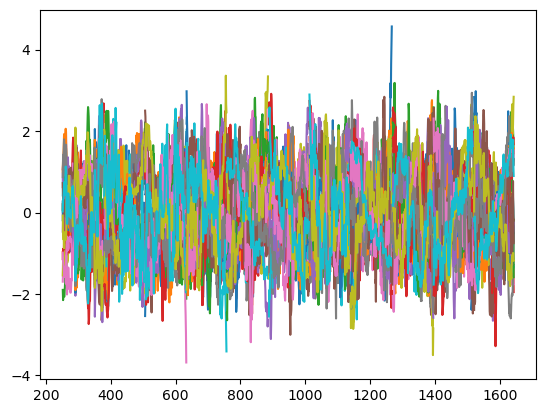

In [7]:
results = []
resumos = []
alpha = 0.05
threshold = 1

read_csv = False

past_days=0

for big_loop in range(0, int(years * 2 - 2)):
    print(f"Starting period {big_loop} | Past days: {past_days}")
    
    twelve_months = int(periods.iloc[big_loop, 3])
    six_months = int(periods.iloc[big_loop + 2, 0])
    
    # Limpeza das ações não listadas no período
    listed1 = log_data.iloc[past_days, :] > 0
    listed2 = log_data.iloc[past_days+int(twelve_months+six_months*(s1218 == 1))-1, :] > 0
    listed = np.multiply(listed1, listed2)
    listed_num = np.sum(listed)
    #print(f"Listed stocks for the period: {listed_num}")
    listed_indexes = np.where(listed > 0)[0]
    #print(f"Listed indexes len {np.shape(listed_indexes)} value {listed_indexes}")
    listed_stocks = log_data.columns[listed_indexes]
    
    #print(f"First listed stockes len {np.shape(listed_stocks)} value {listed_stocks}")
    
    [D, ia, ib] = np.intersect1d(
        ticker2.iloc[:, big_loop], ticker2.iloc[:, big_loop+1], return_indices=True)
    
    ic = np.isin(D, ticker2.iloc[:, big_loop+2])
    
    #print(f"ic len: {np.shape(ic)} | variable: {ic}")
    #print(f"D(ic) len: {np.shape(D[ic])} | variable: {D[ic]}")
    
    Dic_unique_sorted, B_idx = np.unique(D[ic], return_index=True)
    #print(f"Dic_unique_sorted len: {np.shape(Dic_unique_sorted)} | variable: {Dic_unique_sorted}")
    
    listed_union = np.intersect1d(listed_stocks,Dic_unique_sorted)
    #print(f"Listed union len {np.shape(listed_union)} value {listed_union}")
    
    index_listed2 = [log_data.columns.get_loc(i) for i in listed_union if i in log_data]
    index_listed2.sort()
    #print(f"Listed union indexes len {np.shape(index_listed2)} value {index_listed2}")
    
    if os.path.exists(f"../cointegration_data/pvalues_semester_{big_loop}.csv"):
        print("Reading csv")
        try:
            pvalues = np.genfromtxt(f"../cointegration_data/pvalues_semester_{big_loop}.csv", delimiter=',')
            #pvalues = pd.read_csv(f"cointegration_data/pvalues_semester_{j}.csv", header=None, index_col=False)
            gammas = np.genfromtxt(f"../cointegration_data/gammas_semester_{big_loop}.csv", delimiter=',')
            #gammas = pd.read_csv(f"cointegration_data/gammas_semester_{j}.csv", header=None, index_col=False)
        except Exception as e:
            print(e)
    else:
        print("Generating csv")
        result = find_cointegrated_pairs_mod(log_data.iloc[past_days:(past_days+twelve_months),index_listed2]) # 1 ano de formação e 6 meses de teste
        if result is None:
                print("Retornou None")
        else:
            pvalues, gammas = result
        
    pd.DataFrame(pvalues).to_csv(f"../cointegration_data/pvalues_semester_{big_loop}.csv", header=None, index=False)
    pd.DataFrame(gammas).to_csv(f"../cointegration_data/gammas_semester_{big_loop}.csv", header=None, index=False)
    
    print(f"Finished finding cointegrated pairs big_loop {big_loop}")

    try:
        coint_pairs_df = top_coint_pairs(log_data.iloc[past_days:(past_days+twelve_months),index_listed2], pvalues, gammas, alpha, no_pairs)
        print(f"Found top cointegrated pairs big_loop {big_loop}")
        #print(f"coint_pairs_df len: {np.shape(coint_pairs_df)} | value: {coint_pairs_df}")
    except Exception as e:
        print(e)
        print("Exception ao achar top pares cointegrados")
        continue
        
    for i in range(0,coint_pairs_df.shape[0]):
        #print(f"Pair: {coint_pairs_df.iloc[i,:]}")
        
        S1_name = coint_pairs_df.iloc[i, 0]
        S2_name = coint_pairs_df.iloc[i, 1]
        gamma_1_2 = coint_pairs_df.iloc[i, 3]

        S1 = log_data[S1_name].iloc[(past_days+twelve_months):(past_days+twelve_months+six_months)] # periodo de teste
        S2 = log_data[S2_name].iloc[(past_days+twelve_months):(past_days+twelve_months+six_months)] # periodo de teste

        # Spread
        spread = S1 - gamma_1_2*S2
        #print(f"Spread series: {spread}")
        # Pegando o resultado da estratégia
        ret, resumos = calculate_profit(i, spread, threshold, S1_name, S2_name, resumos, big_loop, gamma_1_2)
        
    past_days = past_days + periods.iloc[big_loop, 0]
    
    
cols = ['Operação', 'Semestre', 'Abertura', 'Fechamento', 'Dias', 'Retorno total', 'Ticker 1', 'Ticker 2', 'Converged']
df = pd.DataFrame(resumos, columns = cols)
df['Index'] = df['Ticker 1'].astype(str) + '-' + df['Ticker 2'].astype(str) + '-' + df['Operação'].astype(str)
df['Retorno total - exp'] = np.exp(df['Retorno total'])
df.to_csv("../cointegration_results/threshold_1/operations.csv", sep=',', index=False)


In [ ]:
pd.DataFrame(Rpair).to_csv("../cointegration_results/threshold_1/Rpair.csv", header=None, index=False)
daily_returns = np.sum(Rpair, axis=1)
pd.DataFrame(daily_returns).to_csv("../cointegration_results/threshold_1/daily_returns.csv", header=None, index=False)